# Classically-Boosted Variational Quantum Eigensolver

In [51]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from matplotlib import pyplot as plt
from scipy import linalg

In [52]:
num_repeats = 100

In [53]:
# Define the molecular Hamiltonian
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
basis_set = "sto-3g"
electrons = 2
orbitals = 2
Hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Set the number of iterations of the VQE and stepsize
stepsize = 0.4
max_iterations = 10

# Define the HF initial state and fermionic Hamiltonian
hf_state = qml.qchem.hf_state(electrons, qubits)
fermionic_Hamiltonian = qml.utils.sparse_hamiltonian(Hamiltonian).toarray()

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)

In [54]:
# Number of shots
num_shots_list = np.arange(5, 150, 5)

# Initialize params
energies_VQE = np.zeros(shape=(num_repeats, len(num_shots_list)))
angles_VQE = np.zeros(shape=(num_repeats, len(num_shots_list), num_theta))

# Define the cost function and the circuit
def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf_state,
        singles = singles,
        doubles = doubles)

for rep_idx in range(num_repeats):
    for i ,num_shots in enumerate(num_shots_list):
        print('---VQE for num. of samples %.0f---' %num_shots)
        
        num_shots = int(num_shots)

        # Define a device
        dev = qml.device('default.qubit', wires=qubits, shots=num_shots)

        @qml.qnode(dev)
        def cost_fn(theta):
            circuit_VQE(theta,range(qubits)) # Why define outside?
            return qml.expval(Hamiltonian)

        # Draw circuit
        # qml.drawer.use_style('black_white')
        # qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

        # Gradient descent optimization
        opt = qml.GradientDescentOptimizer(stepsize=stepsize)
        theta = np.zeros(num_theta, requires_grad=True)

        #  Initial energy
        energy = [cost_fn(theta)]
        angle = [theta]

        for n in range(max_iterations):

            theta, prev_energy = opt.step_and_cost(cost_fn, theta)

            energy.append(cost_fn(theta))
            angle.append(theta)

            # conv = np.abs(energy[-1] - prev_energy)

            # if n % 2 == 0:
            #     print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

        # print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
        # print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

        
        # Plot epochs
        # plt.figure(figsize=(10,7))
        # plt.plot(energy ,"x--")
        # plt.xlabel("epoch", fontsize=20)
        # plt.ylabel("energy (Ha)", fontsize=20)
        
        # Append energies and optimized thetas
        # energies_VQE.append(energy[-1])
        energies_VQE[rep_idx, i] = energy[-1]
        angles_VQE[rep_idx, i] = angle[-1]

---VQE for num. of samples 5---
---VQE for num. of samples 10---
---VQE for num. of samples 15---
---VQE for num. of samples 20---
---VQE for num. of samples 25---
---VQE for num. of samples 30---
---VQE for num. of samples 35---
---VQE for num. of samples 40---
---VQE for num. of samples 45---
---VQE for num. of samples 50---
---VQE for num. of samples 55---
---VQE for num. of samples 60---
---VQE for num. of samples 65---
---VQE for num. of samples 70---
---VQE for num. of samples 75---
---VQE for num. of samples 80---
---VQE for num. of samples 85---
---VQE for num. of samples 90---
---VQE for num. of samples 95---
---VQE for num. of samples 100---
---VQE for num. of samples 105---
---VQE for num. of samples 110---
---VQE for num. of samples 115---
---VQE for num. of samples 120---
---VQE for num. of samples 125---
---VQE for num. of samples 130---
---VQE for num. of samples 135---
---VQE for num. of samples 140---
---VQE for num. of samples 145---
---VQE for num. of samples 5---
--

In [55]:
# Obtain HF energy
binary_string = ''.join([str(i) for i in hf_state])
idx0 = int(binary_string, 2)
H11 = fermionic_Hamiltonian[idx0][idx0]

# Circuit that maps a product state
def circuit_product_state(state):
    qml.BasisState(state, range(qubits))
    
# Initialize params
energies_CBVQE = np.zeros(shape=(num_repeats, len(num_shots_list)))
for rep_idx in range(num_repeats):  
    for i, num_shots in enumerate(num_shots_list):
        
        # Obtain VQE energy and optimized thetas
        H22 = energies_VQE[rep_idx, i]
        theta_opt = angles_VQE[rep_idx, i]
        
        # Get crossed terms
        wires = range(qubits + 1)
        dev = qml.device("default.qubit", wires=wires, shots=int(num_shots))
        Vcl = np.identity(2**qubits)
        Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))

        @qml.qnode(dev)
        def hadamard_test(Vq, Vcl, W, component='real'):

            if component == 'imag':
                qml.RX(math.pi/2, wires=wires[1:])

            qml.Hadamard(wires=[0])
            qml.QubitUnitary(W, wires=wires[1:])
            qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
            qml.Hadamard(wires=[0])

            return qml.probs(wires=[0])

        # Compute crossed terms
        H12 = 0
        relevant_basis_states = np.array([[1,1,0,0], [0,1,1,0], [1,0,0,1], [0,0,1,1]], requires_grad=True)
        for j, basis_state in enumerate(relevant_basis_states):
            W = qml.matrix(circuit_product_state)(basis_state)
            probs = hadamard_test(Vq, Vcl, W)
            y = 2*abs(probs[0])-1
            binary_string = ''.join([str(coeff) for coeff in basis_state])
            idx = int(binary_string, 2)
            overlap_H = fermionic_Hamiltonian[idx0][idx]
            H12 += y * overlap_H
            if j == 0:
                y0 = y
        
        H21 = np.conjugate(H12)

        S = np.array([[1, y0],[y0.conjugate(), 1]])
        H = np.array([[H11, H12],[H21, H22]])
        
        evals = linalg.eigvals(H, S)
        
        energies_CBVQE[rep_idx, i] = np.min(evals).real

Text(0, 0.5, 'energy (Ha)')

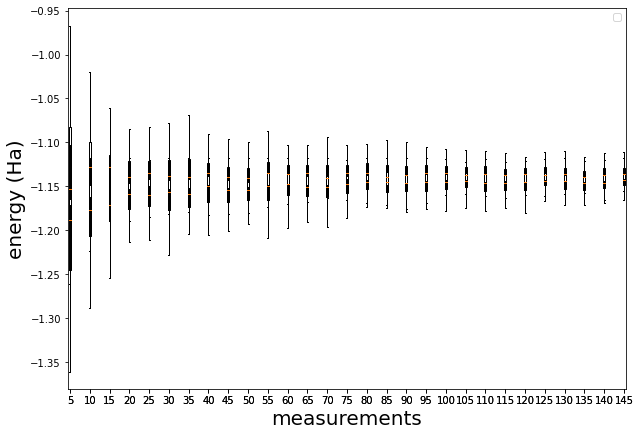

In [56]:
# Plot results
plt.figure(figsize=(10,7))

avg_energies_CBVQE = np.mean(energies_CBVQE, axis=0)
std_eneriges_CBVQE = np.std(energies_CBVQE, axis=0)

avg_energies_VQE = np.mean(energies_VQE, axis=0)
std_eneriges_VQE = np.std(energies_VQE, axis=0)

# plt.plot(num_shots_list, avg_energies_VQE, "x--", label='VQE')

# plt.errorbar(num_shots_list, avg_energies_VQE, yerr=std_eneriges_VQE, fmt='x', label='VQE')
# plt.errorbar(num_shots_list, avg_energies_CBVQE, yerr=std_eneriges_CBVQE, fmt='o', label='CBVQE')

plt.boxplot(energies_CBVQE, positions=num_shots_list, showfliers=False, )
plt.boxplot(energies_VQE, positions=num_shots_list, showfliers=False)

plt.legend()
plt.xlabel("measurements", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

In [57]:
# Print actual GS energy (diagonalize fermionic Hamiltonian)
from scipy.sparse.linalg import eigs
E0 = eigs(fermionic_Hamiltonian)[0][0]
print(np.real(E0))

-1.1361891624647935


In [58]:
print(energies_VQE)
print(energies_CBVQE)

[[-1.17104902 -1.11760627 -1.06742602 ... -1.14573233 -1.13503275
  -1.14289562]
 [-1.18894906 -1.09049887 -1.11155381 ... -1.13618849 -1.1288882
  -1.13859267]
 [-1.18894906 -1.17104902 -1.1233156  ... -1.12521857 -1.14539936
  -1.11923165]
 ...
 [-1.11734892 -1.14419897 -1.14121563 ... -1.14329984 -1.14094274
  -1.13088827]
 [-1.15366369 -1.11734892 -1.12928228 ... -1.14370047 -1.1280788
  -1.13043976]
 [-1.17104902 -1.17104902 -1.18894906 ... -1.1575274  -1.14154059
  -1.12310385]]
[[-1.28831583 -1.16226008 -1.15477103 ... -1.15283524 -1.13829752
  -1.15785679]
 [-1.24289078 -1.19647727 -1.20257423 ... -1.14204429 -1.12913772
  -1.14033628]
 [-1.21987112 -1.22903423 -1.18949992 ... -1.13174575 -1.15370781
  -1.12704931]
 ...
 [-1.20684909 -1.24243658 -1.19777757 ... -1.14338293 -1.1505836
  -1.13852506]
 [-1.22355732 -1.18894906 -1.13243991 ... -1.15238211 -1.12900351
  -1.14768157]
 [-1.20366939 -1.20125533 -1.18964892 ... -1.16028041 -1.14357108
  -1.13881959]]


In [59]:
np.savetxt("./classically_boosted-vqe/data/num_shots_list.csv", num_shots_list, delimiter=", ")
np.savetxt("./classically_boosted-vqe/data/energies_VQE.csv", energies_VQE, delimiter=", ")
np.savetxt("./classically_boosted-vqe/data/energies_CBVQE.csv", energies_CBVQE, delimiter=", ")